# Clone Repo and Install Dependencies

In [1]:
# clone the github repo
!git clone https://github.com/djvaroli/samsung_oct.git samsung_oct

Cloning into 'samsung_oct'...
remote: Enumerating objects: 284, done.
remote: Counting objects: 100% (284/284), done.
remote: Compressing objects: 100% (196/196), done.
remote: Total 284 (delta 137), reused 196 (delta 74), pack-reused 0
Receiving objects: 100% (284/284), 25.80 MiB | 4.74 MiB/s, done.
Resolving deltas: 100% (137/137), done.


In [2]:
!pip install -q wandb

     |████████████████████████████████| 1.8MB 15.7MB/s 
     |████████████████████████████████| 174kB 54.5MB/s 
     |████████████████████████████████| 133kB 53.5MB/s 
     |████████████████████████████████| 102kB 9.6MB/s 
     |████████████████████████████████| 71kB 7.3MB/s 


In [3]:
# isntall all the needed dependencies
!pip install -q -r samsung_oct/requirements.txt

     |████████████████████████████████| 184kB 14.5MB/s 
     |████████████████████████████████| 102kB 9.2MB/s 
     |████████████████████████████████| 102kB 9.3MB/s 
     |████████████████████████████████| 112kB 23.3MB/s 
     |████████████████████████████████| 81kB 8.9MB/s 
     |████████████████████████████████| 3.8MB 31.4MB/s 
     |████████████████████████████████| 81kB 9.1MB/s 
     |████████████████████████████████| 2.9MB 52.1MB/s 
     |████████████████████████████████| 143kB 50.0MB/s 
     |████████████████████████████████| 174kB 45.4MB/s 
     |████████████████████████████████| 3.0MB 50.4MB/s 
     |████████████████████████████████| 1.0MB 54.0MB/s 
     |████████████████████████████████| 296kB 54.0MB/s 
     |████████████████████████████████| 286kB 52.4MB/s 
     |████████████████████████████████| 512kB 38.4MB/s 
     |████████████████████████████████| 645kB 47.3MB/s 
     |████████████████████████████████| 61kB 8.2MB/s 
     |████████████████████████████████| 27.4MB 82.0MB/s 

In [4]:
# install custom utilities
!pip install -q -e samsung_oct/utilities/

In [1]:
# download the files with the data
# change the name of the file at the very end
# dev_data.zip - contains a subset for testing and development purposes
# processed_data.zip - contains the entire dataset for actual model training
DATA_TYPE="processed_data"
FILE = f"{DATA_TYPE}.zip"
!export FILE=$FILE
!gsutil -m cp gs://fourth-brain-course-files/capstone-project/data/$FILE .

Copying gs://fourth-brain-course-files/capstone-project/data/processed_data.zip...
- [1/1 files][  5.4 GiB/  5.4 GiB] 100% Done  39.7 MiB/s ETA 00:00:00           
Operation completed over 1 objects/5.4 GiB.                                      


In [2]:
# unzip the file -q prevents a bunch of printing
!unzip -q $FILE

replace processed_data/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [3]:
from google.colab import auth
import os

# login with gcp and configre project
auth.authenticate_user()
project_id = 'fb-mle-march-21'
os.environ['GOOGLE_CLOUD_PROJECT'] = project_id
!gcloud config set project {project_id}

Updated property [core/project].


In [4]:
# this is not very elegant but it will simplify imports
import sys
path_to_utils = "/content/samsung_oct/utilities/"
if path_to_utils not in sys.path:
  sys.path.append(path_to_utils)

# Pre-Requisites
Here we import packages, load in the data, load in the label mapping.

## Import Packages and Instantiate Global Variables

In [5]:
import json
import glob 
import os
from pathlib import Path

import numpy
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import wandb
from wandb.keras import WandbCallback

from callbacks.callbacks import MachineLearningExperimentTracking
from utils.model_utils import ExtendedModel, get_pre_trained_and_compiled_model
from utils.generator_utils import get_generator_instances, create_flows
from utils.wandb_utils import config_to_dict
from utils.image_utils import get_image_shape_from_flow
sns.set()

In [7]:
PATH_TO_DATA = Path(f"{DATA_TYPE}/data")

In [8]:
!wandb login

wandb: Currently logged in as: djvaroli (use `wandb login --relogin` to force relogin)


# Model Training

## Setting up Weights & Biases Tracking

In [ ]:
config = wandb.config

## Creating Data Generators

We cannot read the data into memory, hence we will use the tensorflow's image data generator to supply the data batch by batch, rather than all at once.

In [44]:
# data augmentation hyperparams 
config.horizontal_flip = True
config.vertical_flip = True
config.rotation_range = 10
config.zoom_range = [0.8, 1.0]
config.zca_whitening = 1e-6
config.channel_shift_range = 0.1
config.fill_mode = "constant"

In [45]:
train_generator, generator = get_generator_instances(**config_to_dict(config))

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:337: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [46]:
flows = create_flows(PATH_TO_DATA, train_generator, generator)

Creating train data flow.
Found 968 images belonging to 4 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


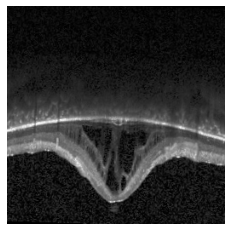

In [50]:
# plot a sample image
# the image will be slightly distorted since we are using the ImageDataGenerator
subsets = list(flows.keys())
flow = flows[subsets[0]]
img_batch, labels_batch = next(flow)
img = img_batch[0]
plt.imshow(img)
plt.axis("off")
flow.reset()

In [12]:
input_shape = img.shape
print(f"Input shape is {input_shape}")

Input shape is (256, 256, 3)


## Global WandB Config Hyperparameters



In [28]:
# model parameters
config.weights = "imagenet"
config.pooling = "max"
config.dropout_rate = 0.3
config.dense_start_dimension = 512
config.num_dense_classification_head = 1
config.dim_shrink_factor = 2
config.dense_classification_head_activation = 'relu'

# optimizer parameters
config.learning_rate = 0.001
config.beta_1 = 0.9
config.beta_2 = 0.999
config.epsilon = 1e-07
config.amsgrad = False

# training hyperparameters
config.epochs = 10

## DenseNet121
Other works have suggested that using a pre-trained DenseNet121 yields the best possible performance. Hence, one of our first steps is to replicate what is essentially the SoA results with DenseNet121.

### Instantiate Model



In [20]:
config.base_model = "densenet"

In [26]:
# this will return a compiled model
model = get_pre_trained_and_compiled_model(input_shape=input_shape, **config.__dict__)

In [ ]:
model.summary()

### Set up Callbacks

In [ ]:
# MachineLearningTrackingExperiment to track train history and save best weights

mlet = MachineLearningExperimentTracking(
    experiment_name=EXPERIMENT_NAME, 
    run_id=wandb.run.id,
    monitor='val_accuracy',
    wandb_run_id=wandb.run.id
)

wandb_callback = WandbCallback(log_weights=True, monitor='val_accuracy')

### Train the model and save to GCS bucket

In [ ]:
model.fit(train_flow, epochs=config.epochs, callbacks=[mlet, wandb_callback], validation_data=val_flow)

# Hyperparameter Sweeps

## Configure Sweep

In [9]:
base_model_name = "resnet50"

sweep_config = {
  "name" : f"{base_model_name}-sweep",
  "method" : "bayes"
}

### Model Sweep Parameters

In [10]:
model_params = {
    "epochs": {
        "values" : [1, 5, 10, 20]
    },
    "pooling": {
        "values": ["max", "avg"]
    },
    "dropout_rate": {
        "distribution": "uniform",
        "min": 0.0,
        "max": 0.5
    },
    "dense_start_dimension": {
        "distribution": "int_uniform",
        "min": 32,
        "max": 512
    },
    "num_dense_classification_head": {
        "values": [0, 1, 2]
    },
    "dim_shrink_factor": {
        "values": [1, 2, 3]
    },
    "dense_classification_head_activation": {
        "values": ["relu", "leaky_relu", "gelu", "selu"]
    }
}

### Optimizer Sweep Hyperparameters

In [11]:
optimizer_params = {
    "learning_rate": {
        "distribution": "uniform",
        "min": 0.0001,
        "max": 0.1
    },
    "beta1": {
        "distribution": "uniform",
        "min": 0.1,
        "max": 0.9
    },
    "beta2": {
        "distribution": "uniform",
        "min": 0.1,
        "max": 0.999
    },
    "epsilon": {
        "distribution": "uniform",
        "min": 1e-08,
        "max": 1e-06
    },
    "amsgrad": {
        "values": [True, False]
    }
}



### Data Augmentation Sweep Parameters

In [12]:
data_params = {
    "horizontal_flip": {
      "values": [True, False]
    },
    "vertical_flip": {
      "values": [True, False]
    },
    "rotation_range": {
      "values": [0, 5, 10]
    },
    "zoom_range": {
      "values": [[1.0, 1.0], [0.9, 1.0], [0.8, 1.0]]
    },
    "zca_whitening": {
        "values": [True, False]
    },
    "zca_epsilon": {
      "distribution": "uniform",
      "min": 1e-7,
      "max": 1e-5
    },
    "channel_shift_range": {
        "values": [0.0, 0.1, 0.2]
    },
    "fill_mode": {
      "values": ["constant", "nearest"]
    }
}

In [13]:
parameters = {
    **data_params,
    **optimizer_params,
    **model_params
}
sweep_config['parameters'] = parameters

In [14]:
metric = {
    'name': 'val_accuracy',
    'goal': 'maximize'   
}
sweep_config['metric'] = metric

## Initialize and Run Sweep

In [19]:
sweep_id = wandb.sweep(sweep_config, project=sweep_config['name'])

Create sweep with ID: 7zf237ec
Sweep URL: https://wandb.ai/djvaroli/resnet50-sweep/sweeps/7zf237ec


In [20]:
def run_sweep():
  with wandb.init() as run:
    config = wandb.config
    config_as_dict = config_to_dict(config)
    
    # the data generators and flows
    generators = get_generator_instances(**config_as_dict)
    train_generator, generator = generators
    flows = create_flows(PATH_TO_DATA, train_generator, generator)

    assert "train" in flows, "Training flow is missing"
    assert "test" in flows, "Test flow is missing"

    train_flow = flows['train']
    test_flow = flows['test']

    input_shape = get_image_shape_from_flow(train_flow)

    # the compiled model
    model = get_pre_trained_and_compiled_model(
        base_model=base_model_name,
        input_shape=input_shape, 
        **config_as_dict
    )

    for epoch in range(config.epochs):
        history = model.fit(train_flow, validation_data=test_flow, workers=8)  # your model training code here
        val_accuracy = history.history['val_accuracy'][-1]
        wandb.log({"val_accuracy": round(val_accuracy * 100, 4), "epoch": epoch})

In [ ]:
wandb.agent(sweep_id, function=run_sweep)

wandb: Agent Starting Run: pwezu85o with config:
wandb: 	amsgrad: False
wandb: 	beta1: 0.4565932808372293
wandb: 	beta2: 0.9961392588488462
wandb: 	channel_shift_range: 0
wandb: 	dense_classification_head_activation: selu
wandb: 	dense_start_dimension: 102
wandb: 	dim_shrink_factor: 2
wandb: 	dropout_rate: 0.25762903856847286
wandb: 	epochs: 20
wandb: 	epsilon: 7.457283082919141e-08
wandb: 	fill_mode: constant
wandb: 	horizontal_flip: True
wandb: 	learning_rate: 0.08839036361605068
wandb: 	num_dense_classification_head: 2
wandb: 	pooling: avg
wandb: 	rotation_range: 5
wandb: 	vertical_flip: False
wandb: 	zca_epsilon: 7.040207378706989e-06
wandb: 	zca_whitening: False
wandb: 	zoom_range: [0.8, 1]
wandb: Currently logged in as: djvaroli (use `wandb login --relogin` to force relogin)


Creating train data flow.
Found 83484 images belonging to 4 classes.
Creating val data flow.
Found 32 images belonging to 4 classes.
Creating test data flow.
Found 968 images belonging to 4 classes.
94773248/94765736 [==============================] - 1s 0us/step


1161/2609 [============>.................] - ETA: 2:03 - loss: 5.7547 - accuracy: 0.3786